<a href="https://colab.research.google.com/github/lucchaves/women-in-tech/blob/master/COL_Women_Seen_From_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Women: Seen from Machine Learning**



## Preliminar steps
Import the packages and modules required for the notebook



In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from matplotlib import pyplot as plt
from matplotlib import rcParams
import matplotlib

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve,f1_score,log_loss
from sklearn.feature_selection import SelectFromModel

import pandas as pd
import numpy as np
import scipy.stats  as stats
import seaborn as sn 
import statsmodels.api as sm
import xgboost as xgb

pd.set_option("display.max_rows", 300)
pd.set_option('display.max_colwidth', None)
pd.set_option('mode.chained_assignment', None)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1RXFrsH4JwNV3oQhMzT9u7aIy87qoGqXf"}) 
downloaded.GetContentFile('individual_women_data_COL.csv')

## Auxiliar functions

In [ ]:
#@title 
def plot_stacked_chart(data, cols_to_group, chart_title, axis_x_name, axis_y_name): # x_col, y_col, , sum_y, sum_x=0.25
  matplotlib.style.use('ggplot') 
  df = data.groupby(cols_to_group).size().unstack()
  df = df.reindex(df.index.get_level_values(0)).sort_values(by=1, ascending=False).head(10)

  ax = df.plot(kind='bar', stacked=True, title=chart_title, color=['#5c9c67', '#bcdbb3'], rot=45, figsize=(10,6))

  ax.set_xlabel(axis_x_name)
  ax.set_ylabel(axis_y_name)
  ax.set_xticklabels(labels = ax.get_xticklabels(), rotation=45, ha="right")

  for p in ax.patches:
      width, height = p.get_width(), p.get_height()
      x, y = p.get_xy() 
      ax.text(x+width/2, 
              y+height/2, 
              '{:.0f}'.format(height), 
              horizontalalignment='right', 
              verticalalignment='center',  color="#313131", fontweight='bold')

In [ ]:
#@title 
def plot_chart(df, x_col, y_col, axis_x_name, axis_y_name, chart_title, sum_y, sum_x=0.25):
    plt.style.use('ggplot')

    x = df[x_col].tolist()
    counts = df[y_col].tolist()

    x_pos = [i for i, _ in enumerate(x)]

    plt.bar(x_pos, counts, color='green')
    plt.xlabel(axis_x_name)
    plt.ylabel(axis_y_name)
    plt.title(chart_title)
    plt.rcParams["figure.figsize"] = (10,8) 
    plt.xticks(x_pos, x)
    
    plt.xticks(rotation=45, ha='right')

    rcParams['xtick.major.pad']='5'

    for i, v in enumerate(counts):
      plt.text(x_pos[i] - sum_x, v + sum_y, str(v), color="#313131", fontweight='bold')

    plt.show()

In [ ]:
#@title 
def df_summary(data):
  res = []
  for c in data.columns:
      res.append([c, data[c].isna().sum(), len(data[c].unique().tolist()), data[c].unique().tolist()])
                  
  nans = pd.DataFrame(res, columns=['column_name', 'count', 'distinct_values', 'values']).sort_values(['count'], ascending = False)
  nans['pct'] = (nans['count']/len(data)) * 100

  return nans[['column_name', 'distinct_values', 'count', 'pct', 'values']]

## Data Ingestion and Target Definition
### **About the data**
The data used for this investigation was provided by *The DHS Program (Demographic and Health Surveys)*. It consists on a Survey with the following characteristics:
* **Country:** Colombia
* **Fieldwork:**	February 2015 - March 2016

Respondents:
* **Households:**	44,614
* **Female:**	38,718 [Age: 13 to 49]
* **Male:** 35,783 [Age: 13 to 59]


Some of the topics covered by the survey are:
* Abortion
* Alcohol consumption
* Birth registration
* Domestic violence
* Early childhood education
* Women's status

Find more information here: [DHS Program - Colombia: Standard DHS, 2015](https://dhsprogram.com/what-we-do/survey/survey-display-476.cfm)


This dataset was already ingested, filtered by gender and contains preselected features that we found interesting for this investigation

In [ ]:
data_raw = pd.read_csv("individual_women_data_COL.csv")
data_raw = data_raw.replace(r'\\n','', regex=True) 
data_raw = data_raw.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [ ]:
len(data_raw)

38718

In [ ]:
data_raw.head()

,CASEID,current_occupation,occupation_area,department,gender,level_school_completed,mother_marital_stat_when_12_14,father_marital_stat_when_12-14,who_lived_with_when_12-14,all_siblings_same_father,all_siblings_same_mother,age_at_first_child,age_father_at_first_child,reason_for_not_getting_pregnant,has_ever_worked,final_say_on_studying,partner_didnt_allow_to_study_work,pregnancy_test_req_when_looking_for_job,sterilization_prove_req_when_looking_for_job,fired_becaused_pregnancy,reason_stop_school,knows_read_and_write,lives_with,afraid_to_tell_partner_about_pregnancy,forced_to_use_contraception_exhusband,forced_to_use_contraception_boyfriend,forced_to_use_contraception_exboyfriend,forced_to_use_contraception_husband,pressure_from_friends_to_have_sex,final_say_on_having_sex,partner_jealous_place,didnt_allow_see_friends_place,limit_family_contact_place,threaten_with_weapon_place,threaten_to_leave_you_place,threaten_to_take_away_children_place,shake_you_place,slap_you_place,hit_you_with_object_place,kick_you_place,attack_with_a_knife_gun_place,tried_to_strangle_burn_place,partner_threaten_withdraw_economic_support,partner_spent_hh_money,partner_take_away_money_or_real_state,controlling_money_place,threaten_withdraw_economic_support_place,didnt_allow_study_work_place,forced_perform_sexual_acts_place,partner_requested_interruption_pregnacy,considered_separating_from_partner_last_12months,reasons_for_wanting_separate_from_partner,didnt_allow_to_see_friends_boyfriend,didnt_allow_to_see_friends_exboyfriend,limit_contact_with_family_boyfriend,limit_contact_with_family_exboyfriend,dressed_you_bad_terms_boyfriend,dressed_you_bad_terms_exboyfriend,forced_by_partner_to_have_sexual_intercourse,forced_to_perform_sexual_acts_expartner,forced_to_perform_sexual_acts_boyfriend,forced_to_perform_sexual_acts_exboyfriend,agrees_most_important_for_women_take_care_house,agrees_men_are_head_of_hh,agrees_women_are_free_to_decide_if_want_to_work,agrees_on_its_normal_men_dont_allow_wives_go_out_alone,would_call_attention_of_friend_who_verbally_abuse_woman,received_information_on_sexual_related_topics,agrees_on_sometimes_is_right_to_hit_women,agrees_on_take_care_children_is_women_responsibility,agrees_on_men_has_last_word_on_hh_decisions,agrees_on_women_need_men_to_be_happy,agrees_on_families_with_a_man_have_less_problems
0,00011215 1,Administrative personnel (similar employment),Clerical,La Guajira,Female,Technical professional (after high school),NaN,NaN,NaN,NaN,NaN,24.0,26.0,NaN,NaN,No one,No,No,No,No,NaN,NaN,NaN,NaN,No,No,No,No,NaN,Respondent alone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00011215 3,"Merchant, vendors",Sales,La Guajira,Female,Professional (towards bachelor degree),NaN,NaN,NaN,NaN,NaN,21.0,23.0,NaN,Yes,Respondent alone,NaN,No,No,No,NaN,NaN,NaN,NaN,No,No,No,No,NaN,Respondent alone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00011215 5,Not working and have never worked,Not working,La Guajira,Female,Professional (towards bachelor degree),Living with partner,Living with partner,Others different from father and mother,Yes,Yes,NaN,NaN,NaN,No,Respondent alone,NaN,No,No,Never pregnant/never worked while pregnant,NaN,NaN,NaN,NaN,No,No,No,No,NaN,Respondent alone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00011317 2,"Professional, technical (similar employment)",Professional/technical/managerial,La Guajira,Female,Professional (towards bachelor degree),NaN,NaN,NaN,NaN,NaN,26.0,28.0,NaN,NaN,Respondent and husband/partner,No,No,No,No,NaN,NaN,NaN,NaN,No,No,No,No,NaN,Respondent alone,Private,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,No,Private,NaN,NaN,NaN,NaN,No,NaN

### **Target Definition**
The target will be women who have suffered some type of abuse, a dummy variable is made with 1s if the women was abused in any way and 0s if she wasn't

In [ ]:
data_raw['target'] = np.where((data_raw['partner_didnt_allow_to_study_work'].isin(['Yes, before last year', 'Yes, last year'])) | \
                              (data_raw['fired_becaused_pregnancy'] == 'Yes') | \
                              (data_raw['forced_to_use_contraception_exhusband'] == 'Yes') | \
                              (data_raw['forced_to_use_contraception_boyfriend'] == 'Yes') | \
                              (data_raw['forced_to_use_contraception_exboyfriend'] == 'Yes') | \
                              (data_raw['forced_to_use_contraception_husband'] == 'Yes') | \
                              (data_raw['final_say_on_having_sex'].isin(['Husband/partner alone', 'Someone else'])) | \
                              (data_raw['didnt_allow_see_friends_place'].notnull()) | \
                              (data_raw['limit_family_contact_place'].notnull()) | \
                              (data_raw['threaten_with_weapon_place'].notnull()) | \
                              (data_raw['threaten_to_leave_you_place'].notnull()) | \
                              (data_raw['threaten_to_take_away_children_place'].notnull()) | \
                              (data_raw['shake_you_place'].notnull()) | \
                              (data_raw['slap_you_place'].notnull()) | \
                              (data_raw['hit_you_with_object_place'].notnull()) | \
                              (data_raw['kick_you_place'].notnull()) | \
                              (data_raw['attack_with_a_knife_gun_place'].notnull()) | \
                              (data_raw['tried_to_strangle_burn_place'].notnull()) | \
                              (data_raw['partner_threaten_withdraw_economic_support'].isin(['Yes, before last year', 'Yes, last year'])) | \
                              (data_raw['controlling_money_place'].notnull()) | \
                              (data_raw['threaten_withdraw_economic_support_place'].notnull()) | \
                              (data_raw['forced_perform_sexual_acts_place'].notnull()) | \
                              (data_raw['partner_requested_interruption_pregnacy'] == 'Yes') | \
                              (data_raw['didnt_allow_to_see_friends_boyfriend'] == 'Yes') | \
                              (data_raw['didnt_allow_to_see_friends_exboyfriend'] == 'Yes') | \
                              (data_raw['limit_contact_with_family_boyfriend'] == 'Yes') | \
                              (data_raw['limit_contact_with_family_exboyfriend'] == 'Yes') | \
                              (data_raw['forced_by_partner_to_have_sexual_intercourse'] == 'Yes') | \
                              (data_raw['forced_to_perform_sexual_acts_expartner'] == 'Yes') | \
                              (data_raw['forced_to_perform_sexual_acts_boyfriend'] == 'Yes') | \
                              (data_raw['forced_to_perform_sexual_acts_exboyfriend'] == 'Yes'), 1, 0)

Then, drop the features that were use to define the target, so they don't interfere with the model fit

In [ ]:
data = data_raw.drop(['CASEID', 'gender'], axis=1)
target_features = ['partner_didnt_allow_to_study_work', 
                   'fired_becaused_pregnancy', 
                   'forced_to_use_contraception_exhusband',
                   'forced_to_use_contraception_boyfriend',
                   'forced_to_use_contraception_exboyfriend',
                   'forced_to_use_contraception_husband',
                   'final_say_on_having_sex', 'didnt_allow_see_friends_place',
                   'limit_family_contact_place', 'threaten_with_weapon_place',
                   'threaten_to_leave_you_place', 
                   'threaten_to_take_away_children_place', 'shake_you_place', 
                   'slap_you_place', 'hit_you_with_object_place', 
                   'kick_you_place', 'attack_with_a_knife_gun_place',
                   'tried_to_strangle_burn_place', 
                   'partner_threaten_withdraw_economic_support', 
                   'controlling_money_place', 
                   'threaten_withdraw_economic_support_place',
                   'forced_perform_sexual_acts_place',
                   'partner_requested_interruption_pregnacy',
                   'didnt_allow_to_see_friends_boyfriend',
                   'didnt_allow_to_see_friends_exboyfriend',
                   'limit_contact_with_family_boyfriend',
                   'limit_contact_with_family_exboyfriend',
                   'forced_by_partner_to_have_sexual_intercourse',
                   'forced_to_perform_sexual_acts_expartner',
                   'forced_to_perform_sexual_acts_boyfriend',
                   'forced_to_perform_sexual_acts_exboyfriend']

data = data.drop(target_features, axis=1)

The size of the resulting target is as follows:


In [ ]:
display(data.groupby(['target']).size().reset_index(name='counts'))

,target,counts
0,0,23260
1,1,15458


It shows that the target is balanced enough, since the percentage of 1s is 39.92% of the overall observations. But, this means that almost 40% among the women surveyed has experienced some kind of abuse, which is an alarming number.

## Data Exploration

For a better understanding of the data, some features were selected to see the distribution.

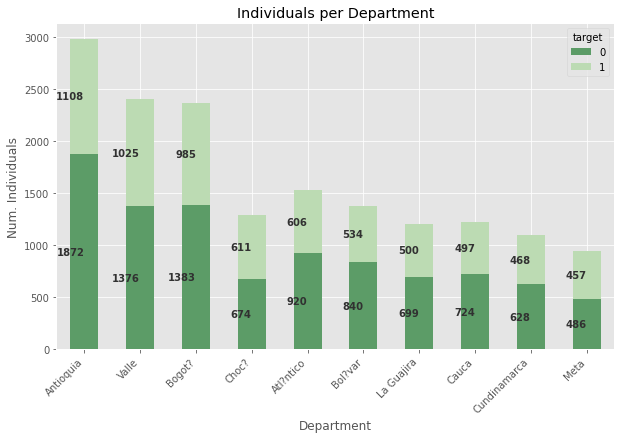

In [ ]:
#@title Most of the victims surveyed are from Antioquia, Valle, and Bogotá.
plot_stacked_chart(data, ['department', 'target'], 'Individuals per Department', 'Department', 'Num. Individuals')


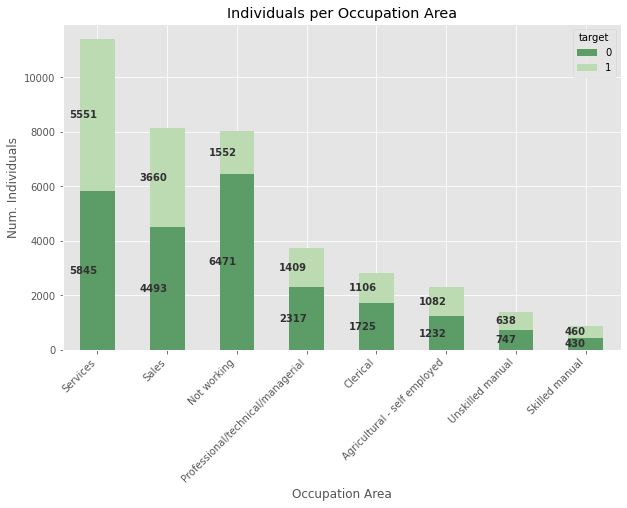

In [ ]:
#@title Services and Sales are the most common Occupation Areas between the women surveyed. A lot of women don't work at all.
plot_stacked_chart(data, ['occupation_area', 'target'], 'Individuals per Occupation Area', 'Occupation Area', 'Num. Individuals')

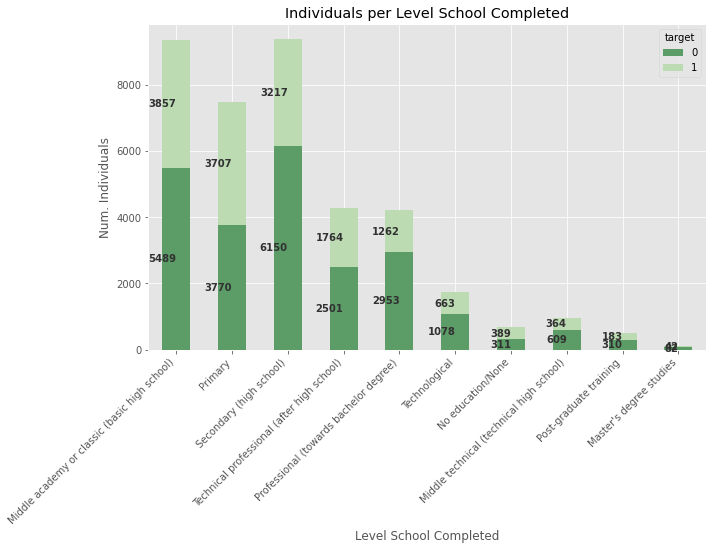

In [ ]:
#@title A significant number of women surveyed only finished Primary or Secondary Education.
plot_stacked_chart(data, ['level_school_completed', 'target'], 'Individuals per Level School Completed', 'Level School Completed', 'Num. Individuals')

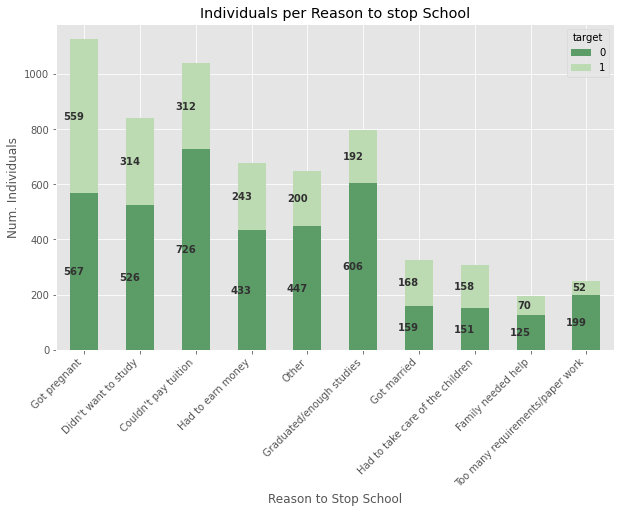

In [ ]:
#@title Getting pregnant is the most common reason to stop school.
plot_stacked_chart(data, ['reason_stop_school', 'target'], 'Individuals per Reason to stop School', 'Reason to Stop School', 'Num. Individuals')

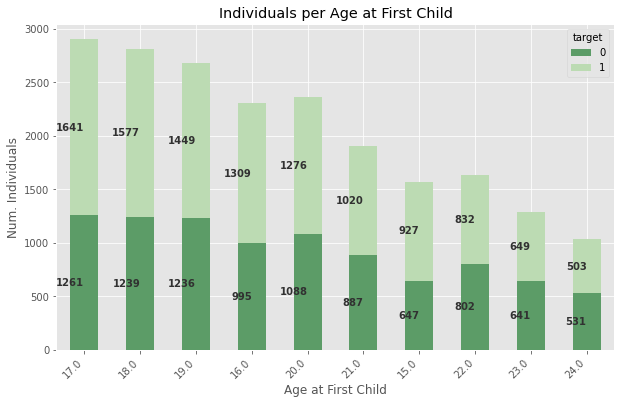

In [ ]:
#@title Almost 53% of the women surveyed got pregnant for the first time before turning 25.
plot_stacked_chart(data, ['age_at_first_child', 'target'], 'Individuals per Age at First Child', 'Age at First Child', 'Num. Individuals')


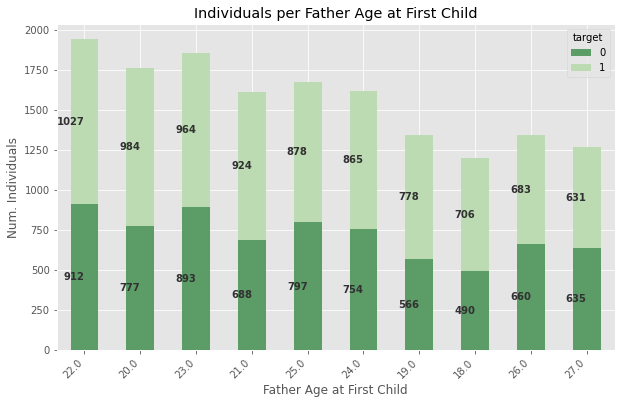

In [ ]:
#@title 40% of the women surveyed indicated that their partners were adult men when they had their first child.
plot_stacked_chart(data, ['age_father_at_first_child', 'target'], 'Individuals per Father Age at First Child', 'Father Age at First Child', 'Num. Individuals')

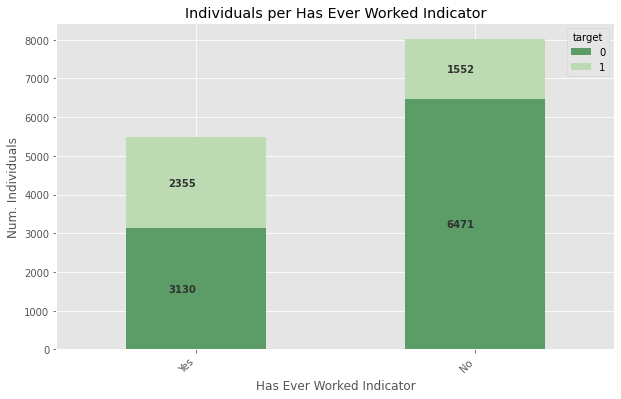

In [ ]:
#@title 20% of the women surveyed have never worked. 65% didn't answer.
plot_stacked_chart(data, ['has_ever_worked', 'target'], 'Individuals per Has Ever Worked Indicator', 'Has Ever Worked Indicator', 'Num. Individuals')

### Train and Test data 
The dataset is divided in two, the train dataset that represents 70% of the overall data and is used for fitting the model and the test dataset represents the rest 30% of the whole dataset and is used to validate the model results 

In [ ]:
target = data['target'].copy()
X = data.drop('target', axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=0)

## Data Wrangling 
The data is prepared to be used in the model

### Handling missing values

Add 'NA' as category on the corresponding features, because in some cases the question didn't apply so this isn't really missing data


In [ ]:
new_cat = ['afraid_to_tell_partner_about_pregnancy',
           'dressed_you_bad_terms_exboyfriend',	
           'dressed_you_bad_terms_boyfriend', 'partner_jealous_place',
           'considered_separating_from_partner_last_12months',
           'partner_spent_hh_money', 'partner_take_away_money_or_real_state',
           'age_father_at_first_child', 'age_at_first_child',
           'sterilization_prove_req_when_looking_for_job', 'current_occupation',
           'pressure_from_friends_to_have_sex',
           'reasons_for_wanting_separate_from_partner', 
           'didnt_allow_study_work_place', 'occupation_area', 
           'final_say_on_studying', 'level_school_completed', 'department',
           'all_siblings_same_father', 'all_siblings_same_mother',
           'reason_for_not_getting_pregnant']

X_train[new_cat].fillna(value='NA', inplace=True)
X_test[new_cat].fillna(value='NA', inplace=True)

### Pre-select variables based on NAs %

Create a summary per column with the percentage of NAs, so the features with less missing data are easily chosen

In [ ]:
nans = df_summary(X_train)
nans.head(15)

,column_name,distinct_values,count,pct,values
11,reason_for_not_getting_pregnant,7,26682,98.450299,"[nan, Partner problem, Illness, Respondent problem, Couple's problem, Other, Don't know]"
19,afraid_to_tell_partner_about_pregnancy,3,26206,96.693971,"[nan, No, Yes]"
18,lives_with,8,25198,92.974688,"[nan, Only with biological mother, Others different from father and mother, Biological father and mother, Biological mother and stepfather, Only with biological father, Biological father and stepmother, Alone]"
24,didnt_allow_study_work_place,4,24562,90.627998,"[nan, Private, Both public/private, Public]"
26,reasons_for_wanting_separate_from_partner,9,23290,85.934617,"[nan, Domestic violence, Other, Doesn't comply with his duties as father/husband, Regularly drunk, Husband unfaithful, Mutual agreement, Use narcotic drugs, Different sexuality needs]"
16,reason_stop_school,12,22717,83.820382,"[Had to earn money, Too many requirements/paper work, nan, Got married, Graduated/enough studies, Got pregnant, Didn't want to study, Couldn't pay tuition, Other, Had to take care of the children, Family needed help, Don't know]"
27,dressed_you_bad_terms_boyfriend,3,22637,83.525201,"[nan, No, Yes]"
28,dressed_you_bad_terms_exboyfriend,3,22637,83.525201,"[nan, No, Yes]"
20,pressure_from_friends_to_have_sex,5,22317,82.344476,"[nan, No pressure, Pressure from half of female friends, A lot of pressure (from all friends), Pressure from more than half of female friends]"
17,knows_read_and_write,3,21449,79.141761,"[nan, Yes, No]"


The variables with less than 67% of missing values were chosen for this model, the missing values are filled with the mode of the respective column

In [ ]:
replace_nan = nans[nans['pct'] < 67]['column_name']

for c in replace_nan:
  mode = X_train[c].mode()
  
  X_train[c] = np.where(X_train[c].isnull(), mode, X_train[c])
  X_test[c] = np.where(X_test[c].isnull(), mode, X_test[c]) # Fill missing values on Test with the Train mode

### Data Cleaning

There are different types of data in the dataset, first the dummy variables, which are cleaned by putting a 1 if there is a "Yes" and a 0 otherwise.
 

In [ ]:
yes_no = ['received_information_on_sexual_related_topics', 'has_ever_worked']

for c in yes_no:
    X_train[c] = np.where(X_train[c] == 'Yes', 1, 0)
    X_test[c] = np.where(X_test[c] == 'Yes', 1, 0)

Then there are categorical ordinal features, the categories of this features can be sorted, so they are replaced by sorted numbers

In [ ]:
cat = ['agrees_men_are_head_of_hh', 
       'agrees_women_are_free_to_decide_if_want_to_work', 
       'agrees_most_important_for_women_take_care_house', 
       'agrees_on_sometimes_is_right_to_hit_women', 
       'agrees_on_take_care_children_is_women_responsibility',
       'agrees_on_men_has_last_word_on_hh_decisions', 
       'agrees_on_women_need_men_to_be_happy', 
       'agrees_on_families_with_a_man_have_less_problems', 
       'pregnancy_test_req_when_looking_for_job']
       
all_cat = {}
for column in cat:
  X_train[column] = X_train[column].astype(str)
  X_test[column] = X_test[column].astype(str)

  categories = X_train[column].unique()
  categories = sorted(categories)
  values = range(1, len(categories)+1)
  cat_dict = dict(zip(categories, values))
  all_cat.update({column:cat_dict})

X_train = X_train.replace(all_cat)
X_test = X_test.replace(all_cat)

Finally, there are categorical nominal features, the order of their categories has no meaning so new dummy variables are created for each category


In [ ]:
create_dummies = ['afraid_to_tell_partner_about_pregnancy',
                  'dressed_you_bad_terms_exboyfriend',	
                  'dressed_you_bad_terms_boyfriend', 'partner_jealous_place',
                  'considered_separating_from_partner_last_12months',
                  'partner_spent_hh_money', 
                  'partner_take_away_money_or_real_state',
                  'age_father_at_first_child', 'age_at_first_child',
                  'sterilization_prove_req_when_looking_for_job', 
                  'current_occupation', 'pressure_from_friends_to_have_sex',
                  'reasons_for_wanting_separate_from_partner', 
                  'didnt_allow_study_work_place', 'occupation_area', 
                  'final_say_on_studying', 'level_school_completed', 
                  'all_siblings_same_father', 'all_siblings_same_mother', 
                  'reason_for_not_getting_pregnant', 'department']

for column in create_dummies:
    X_train[column] = X_train[column].astype(str)
    X_test[column] = X_test[column].astype(str)

df_dummies_train = pd.get_dummies(X_train[create_dummies])
df_dummies_test = pd.get_dummies(X_test[create_dummies])

X_train[df_dummies_train.columns] = df_dummies_train
X_test[df_dummies_test.columns] = df_dummies_test

X_train = X_train.drop(create_dummies, axis = 1)
X_test = X_test.drop(create_dummies, axis = 1)

The summary is recalculated to make sure all the missing data was filled properly

In [ ]:
nans2_train = df_summary(X_train)
nans2_test = df_summary(X_test)

nans2_train.head(15)

,column_name,distinct_values,count,pct,values
7,lives_with,8,25198,92.974688,"[nan, Only with biological mother, Others different from father and mother, Biological father and mother, Biological mother and stepfather, Only with biological father, Biological father and stepmother, Alone]"
5,reason_stop_school,12,22717,83.820382,"[Had to earn money, Too many requirements/paper work, nan, Got married, Graduated/enough studies, Got pregnant, Didn't want to study, Couldn't pay tuition, Other, Had to take care of the children, Family needed help, Don't know]"
6,knows_read_and_write,3,21449,79.141761,"[nan, Yes, No]"
0,mother_marital_stat_when_12_14,9,18383,67.828943,"[Living with partner, nan, Married, Separated, Never in union, Widowed, Divorced, Deceased, Don't know]"
2,who_lived_with_when_12-14,8,18383,67.828943,"[Biological father and mother, nan, Biological mother and stepfather, Only with biological mother, Others different from father and mother, Only with biological father, Biological father and stepmother, Alone]"
1,father_marital_stat_when_12-14,9,18383,67.828943,"[Living with partner, nan, Married, Separated, Deceased, Don't know, Divorced, Widowed, Never in union]"
11,agrees_on_its_normal_men_dont_allow_wives_go_out_alone,4,18243,67.312375,"[nan, Disagrees, Neither agrees nor disagrees, Agrees]"
12,would_call_attention_of_friend_who_verbally_abuse_woman,5,18243,67.312375,"[nan, Would do it, Wouldn't do it, Has already done it, Refuse to answer]"
156,reasons_for_wanting_separate_from_partner_Regularly drunk,2,0,0.000000,"[0, 1]"
161,didnt_allow_study_work_place_Public,2,0,0.000000,"[0, 1]"


Finally, the variables with no missing data are chosen

In [ ]:
cols_to_select_train = nans2_train[nans2_train['pct'] == 0]['column_name'].tolist()
cols_to_select_test = nans2_test[nans2_test['pct'] == 0]['column_name'].tolist()

## Modeling process

Create dataset for modeling with the features selected before


In [ ]:
X_train = X_train[cols_to_select_train]
X_test = X_test[cols_to_select_test]

to_model = pd.concat([X_train, y_train], axis=1)

### Feature Selection 


The first step is to calculate the Pearson correlation of each feature with the target feature

In [ ]:
cols_to_exclude = ['target'] 

corr_vars = list(to_model.drop(columns=cols_to_exclude).columns.values)

corr_values = []
p_values = []
for col in corr_vars:
    #print(col)
    values = stats.pearsonr(to_model['target'], to_model[col])
    corr_values.append(values[0])
    p_values.append(values[1])

    
corr_with_target = pd.DataFrame({'column_name': corr_vars, 'pearson_corr': corr_values, 'pearson_p_value': p_values})
corr_with_target = corr_with_target.sort_values(by=['pearson_corr'], ascending=False) # Sort values by corr
corr_with_target = corr_with_target.reindex(corr_with_target.pearson_corr.abs().sort_values(ascending=False).index)

corr_with_target['pearson_corr'] = corr_with_target['pearson_corr'].abs()
display(corr_with_target.head(15))

,column_name,pearson_corr,pearson_p_value
168,partner_jealous_place_nan,0.540946,0.0
12,didnt_allow_study_work_place_nan,0.396490,0.0
142,partner_spent_hh_money_No,0.384225,0.0
166,partner_jealous_place_Private,0.375892,0.0
2,didnt_allow_study_work_place_Private,0.359171,0.0
157,considered_separating_from_partner_last_12months_No,0.355423,0.0
4,reasons_for_wanting_separate_from_partner_nan,0.355423,0.0
143,considered_separating_from_partner_last_12months_Yes,0.355423,0.0
116,"partner_spent_hh_money_Yes, last year",0.319394,0.0
129,age_father_at_first_child_22.0,0.318306,0.0


In [ ]:
target = to_model['target']
to_model = to_model.drop('target', axis=1)

The features with more than 25% of correlation are chosen for the model

In [ ]:
selected_features = corr_with_target[corr_with_target['pearson_corr'] > 0.25]['column_name'].tolist()
print(len(selected_features))
to_model = to_model[selected_features]

14


### Fitting model
The model was fitted with the train dataset and using the GLM function from statsmodel module. 

In [ ]:
logit_model = sm.GLM(target, to_model, family=sm.families.Binomial())
result = logit_model.fit()
result.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: divide by zero encount

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                27102
Model:                            GLM   Df Residuals:                    27089
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 03 Sep 2020   Deviance:                          nan
Time:                        18:55:14   Pearson chi2:                 2.72e+19
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
partner_jealous_place_nan                                   -1.928e+15   2.33e+06  -8.29e+08      0.000   -1.93e+15   -1.93e+15
didnt_allow_study_work_place_nan                            -3.968e+15    3.5e+06  -1.13e+09      0.000   -3.97e+15   -3.97e+15
partner_spent_hh_money_No                                   -1.743e+15    2.4e+06  -7.28e+08      0.000   -1.74e+15   -1.74e+15
partner_jealous_place_Private                               -2.507e+14   2.33e+06  -1.08e+08      0.000   -2.51e+14   -2.51e+14
didnt_allow_study_work_place_Private                        -4.474e+14   3.64e+06  -1.23e+08      0.000   -4.47e+14   -4.47e+14
considered_separating_from_partner_last_12months_No          1.806e+15   2.19e+06   8.24e+08      0.000    1.81e+15    1.81e+15
reasons_for_wanting_separate_from_partner_nan                1.806e+15   2.19e+06   8.24e+08      0.000    1.81e+15    1.81e+15
considered_separating_from_partner_last_12months_Yes         5.148e+15   4.62e+06   1.11e+09      0.000    5.15e+15    5.15e+15
partner_spent_hh_money_Yes, last year                       -3.098e+14   2.72e+06  -1.14e+08      0.000    -3.1e+14    -3.1e+14
age_father_at_first_child_22.0                                1.54e+15   1.37e+06   1.12e+09      0.000    1.54e+15    1.54e+15
age_at_first_child_17.0                                     -3.917e+13   1.32e+06  -2.97e+07      0.000   -3.92e+13   -3.92e+13
reasons_for_wanting_separate_from_partner_Domestic violence -2.481e+14    2.2e+06  -1.13e+08      0.000   -2.48e+14   -2.48e+14
partner_jealous_place_Both public/private                    1.035e+14   2.82e+06   3.67e+07      0.000    1.03e+14    1.03e+14
pressure_from_friends_to_have_sex_nan                        1.569e+15   1.29e+06   1.21e+09      0.000    1.57e+15    1.57e+15
===============================================================================================================================
"""

### Metrics: Confusion Matrix and Accuracy

/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
No handles with labels found to put in legend.


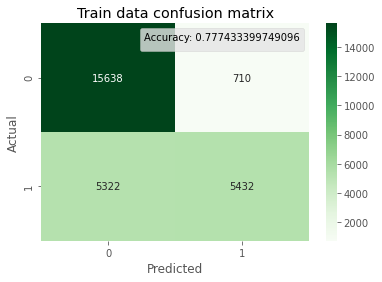

In [ ]:
#@title 
y_predtest = result.predict(X_test[selected_features])
y_predtrain = result.predict(X_train[selected_features])
y_bintest = [1 if x >= 0.5 else 0 for x in y_predtest]
y_bintrain = [1 if x >= 0.5 else 0 for x in y_predtrain]

#confusion matrix for the train dataset
confusion1 = confusion_matrix(y_train, y_bintrain)
accuracy1 = (confusion1[0][0] + confusion1[1][1]) / X_train.shape[0]
    
#confusion matrix for the test dataset
confusion2 = confusion_matrix(y_test, y_bintest)
accuracy2 = (confusion2[0][0] + confusion2[1][1]) / X_test.shape[0]

data = {'y_Actual': y_train, 'y_Predicted': y_bintrain}

aux = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
CM = pd.crosstab(aux['y_Actual'], aux['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(CM,annot=True,cmap='Greens', fmt='g')
plt.title('Train data confusion matrix')
plt.legend(title = 'Accuracy: '+ str(accuracy1))
plt.show()


No handles with labels found to put in legend.


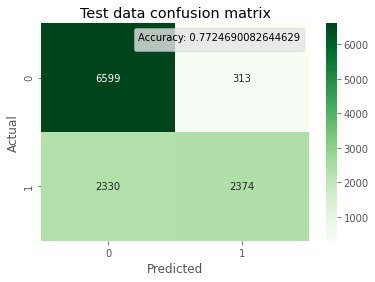

In [ ]:
#@title 
data = {'y_Actual': y_test, 'y_Predicted': y_bintest}

aux = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
CM = pd.crosstab(aux['y_Actual'], aux['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(CM,annot=True,cmap='Greens', fmt='g')
plt.title('Test data confusion matrix')
plt.legend(title = 'Accuracy: ' + str(accuracy2))
plt.show()

### Metrics: ROC curve and AUC for the test dataset

No handles with labels found to put in legend.


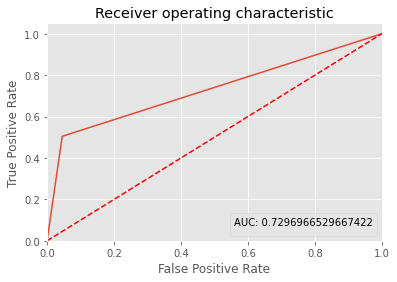

In [ ]:
#@title 
logit_roc_auc = roc_auc_score(y_test, y_predtest)
#print(logit_roc_auc)
#The ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_predtest)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(title = 'AUC: '+ str(logit_roc_auc),loc="lower right")
plt.savefig("Log_ROC")
plt.show()

### Metrics: F1 Score

In [ ]:
print(f1_score(y_train, y_bintrain, average = "binary"))
print(f1_score(y_test, y_bintest, average = "binary"))

0.6429924242424243
0.6424029224732783


### Metrics: Log Loss


In [ ]:
print(log_loss(y_train, y_bintrain))
print(log_loss(y_test, y_bintest))

7.687198986358079
7.858663592092337


The model can perform better if a more sofisticated feature selection algorith was used


## Modeling process 2.0

For the upgrade of the model, the feature selection algorithm used was the one provided by the XGBoost module 

In [ ]:
gbm = xgb.XGBClassifier(max_depth=5, n_estimators= 60, learning_rate=0.05)
embeded_xgb_selector = SelectFromModel(gbm, threshold= 0.004)
embeded_xgb_selector.fit(X_train, y_train)
embeded_xgb_support = embeded_xgb_selector.get_support()
selected_features = X_train.loc[:,embeded_xgb_support].columns.tolist()
print(len(selected_features))
X_train = X_train[selected_features]


22


After the feature selection, the modeling process is the same as the one done 
before

### Fitting model
The model was fitted with the train dataset and using the GLM function from statsmodel module. 

In [ ]:
logit_model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
result = logit_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                27102
Model:                            GLM   Df Residuals:                    27080
Model Family:                Binomial   Df Model:                           21
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11286.
Date:                Thu, 03 Sep 2020   Deviance:                       22572.
Time:                        18:55:27   Pearson chi2:                 4.72e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
reasons_for_wanting_separate_from_partner_nan                  -1.0409      0.062    -16.720      0.000      -1.163      -0.919
reasons_for_wanting_separate_from_partner_Domestic violence     1.0355      0.117      8.839      0.000       0.806       1.265
didnt_allow_study_work_place_nan                               -4.4072      0.248    -17.804      0.000      -4.892      -3.922
pressure_from_friends_to_have_sex_nan                           0.6515      0.068      9.625      0.000       0.519       0.784
final_say_on_studying_Husband/partner alone                     1.0405      0.132      7.868      0.000       0.781       1.300
final_say_on_studying_Respondent alone                         -0.0708      0.054     -1.310      0.190      -0.177       0.035
final_say_on_studying_Respondent and husband/partner           -0.3071      0.064     -4.799      0.000      -0.432      -0.182
final_say_on_studying_Someone else                              0.6126      0.078      7.843      0.000       0.459       0.766
level_school_completed_Primary                                  0.2984      0.043      6.971      0.000       0.215       0.382
partner_take_away_money_or_real_state_No                       -1.1582      0.195     -5.951      0.000      -1.540      -0.777
age_father_at_first_child_22.0                                 -0.4089      0.056     -7.293      0.000      -0.519      -0.299
partner_spent_hh_money_No                                      -1.9767      0.085    -23.359      0.000      -2.143      -1.811
pregnancy_test_req_when_looking_for_job                         0.0619      0.025      2.472      0.013       0.013       0.111
agrees_on_take_care_children_is_women_responsibility           -0.0301      0.053     -0.569      0.569      -0.134       0.074
agrees_on_men_has_last_word_on_hh_decisions                    -0.0203      0.054     -0.377      0.706      -0.126       0.085
dressed_you_bad_terms_exboyfriend_Yes                           1.4788      0.145     10.201      0.000       1.195       1.763
dressed_you_bad_terms_exboyfriend_nan                           8.9287      0.366     24.412      0.000       8.212       9.646
dressed_you_bad_terms_boyfriend_No                              9.3726      0.369     25.429      0.000       8.650      10.095
partner_jealous_place_Both public/private                       0.7654      0.174      4.408      0.000       0.425       1.106
partner_jealous_place_Private                                  -0.7188      0.116     -6.188      0.000      -0.946      -0.491
partner_jealous_place_nan                                      -2.3166      0.114    -20.314      0.000      -2.540      -2.093
age_at_firs

### Metrics: Confusion Matrix and Accuracy


No handles with labels found to put in legend.


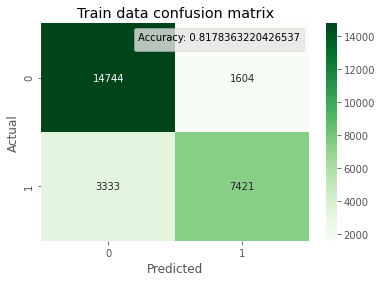

In [ ]:
#@title 
y_predtest = result.predict(X_test[selected_features])
y_predtrain = result.predict(X_train[selected_features])
y_bintest = [1 if x >= 0.5 else 0 for x in y_predtest]
y_bintrain = [1 if x >= 0.5 else 0 for x in y_predtrain]

#confusion matrix for the train dataset
confusion1 = confusion_matrix(y_train, y_bintrain)
accuracy1 = (confusion1[0][0] + confusion1[1][1]) / X_train.shape[0]
    
#confusion matrix for the test dataset
confusion2 = confusion_matrix(y_test, y_bintest)
accuracy2 = (confusion2[0][0] + confusion2[1][1]) / X_test.shape[0]

data = {'y_Actual': y_train, 'y_Predicted': y_bintrain}

aux = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
CM = pd.crosstab(aux['y_Actual'], aux['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(CM,annot=True,cmap='Greens', fmt='g')
plt.title('Train data confusion matrix')
plt.legend(title = 'Accuracy: '+ str(accuracy1))
plt.show()


No handles with labels found to put in legend.


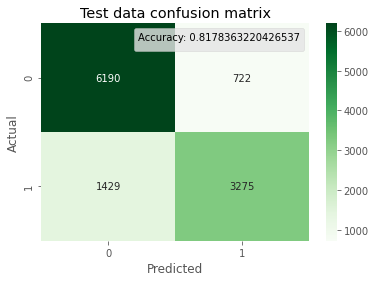

In [ ]:
#@title 
data = {'y_Actual': y_test, 'y_Predicted': y_bintest}

aux = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
CM = pd.crosstab(aux['y_Actual'], aux['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(CM,annot=True,cmap='Greens', fmt='g')
plt.title('Test data confusion matrix')
plt.legend(title = 'Accuracy: '+ str(accuracy1))
plt.show()

### Metrics: ROC curve and AUC

No handles with labels found to put in legend.


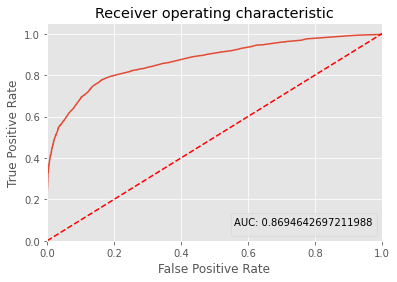

In [ ]:
#@title 
logit_roc_auc = roc_auc_score(y_test, y_predtest)
#print(logit_roc_auc)   
#The ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_predtest)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(title = 'AUC: ' + str(logit_roc_auc), loc="lower right")
plt.savefig("Log_ROC")
plt.show()

### Metrics: F1 Score

In [ ]:
print(f1_score(y_train, y_bintrain, average = "binary"))
print(f1_score(y_test, y_bintest, average = "binary"))

0.7503918297183882
0.7527870359728767


### Metrics: Log Loss

In [ ]:
print(log_loss(y_train, y_bintrain))
print(log_loss(y_test, y_bintest))

6.291757863476942
6.395789026755982
